# Using RandomForest Classifier for land cover mapping using sentinel 2



### Setup Notebook

In [ ]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install scikit-learn
%pip install treeinterpreter

In [ ]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

### Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/MyDrive/model_data"

### Prepare Data

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [ ]:
X=np.load("/content/drive/MyDrive/model_data/image.npy")
y=np.load("/content/drive/MyDrive/model_data/label.npy")
X.shape, y.shape

((35627, 7), (35627,))

In [ ]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 5, 4)
ndwi = band_index(X, 3, 5)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape, y.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until


((35627, 9), (35627,))

Now were going to split 25% of the data to reserve for testing  the quality of the trained model.

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [ ]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{1: 0.00018145527127563056,
 2: 0.00018590816136828406,
 3: 0.000184945441094877,
 4: 0.00019642506383814575,
 5: 0.00018754688672168043}

### Train RandomForest

In [ ]:
# initialize a RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=1200,
    class_weight=class_weight_dict,
    max_depth=15,
    n_jobs=-1,
    verbose=1,
    random_state=0
    )

In [ ]:
# fit the model to the data (training)
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={1: 0.00018145527127563056,
                                     2: 0.00018590816136828406,
                                     3: 0.000184945441094877,
                                     4: 0.00019642506383814575,
                                     5: 0.00018754688672168043},
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

# PLOT VARIABLE IMPORTANCE

Feature: 0, Score: 0.09620
Feature: 1, Score: 0.07115
Feature: 2, Score: 0.07509
Feature: 3, Score: 0.06333
Feature: 4, Score: 0.13843
Feature: 5, Score: 0.17930
Feature: 6, Score: 0.17437
Feature: 7, Score: 0.08459
Feature: 8, Score: 0.11753


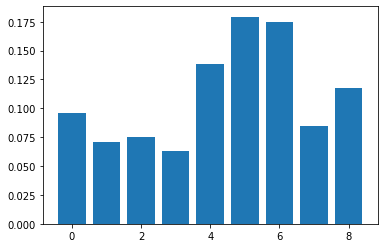

In [ ]:
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# predict on X_test to evaluate the model
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:    1.7s finished


### Assess the Model

In [ ]:
print(confusion_matrix(y_test,preds))

[[1737    0   10   49    0]
 [ 119 1618   65   24   22]
 [   0    1 1648    4  124]
 [  80    0   49 1576   13]
 [   5    0  124    4 1635]]


In [ ]:
print(accuracy_score(y_test, preds))

0.9221960255978444


In [ ]:
classes=['agri', 'builtup', 'mangrove', 'shrub', 'water']

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


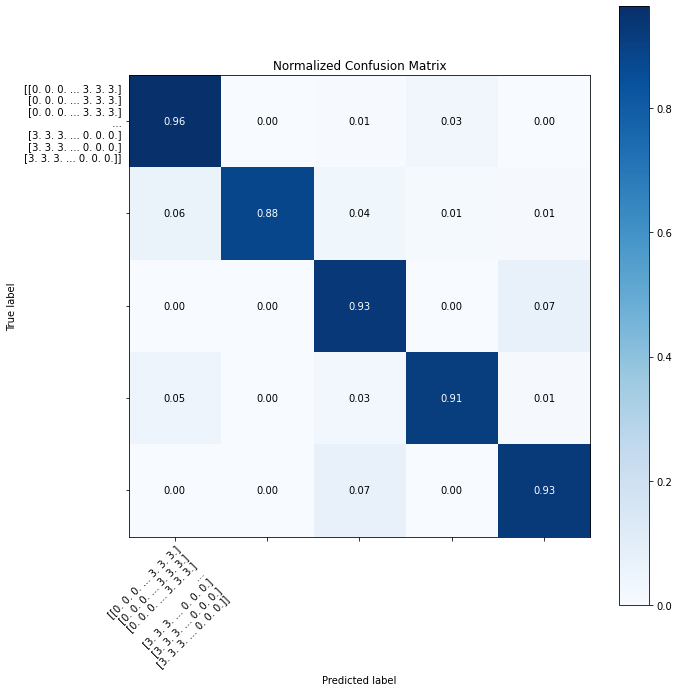

In [ ]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

You can see the most often confused classes are shrub with builtup

In [ ]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(model, X_test[:sample])
c = np.sum(contributions, axis=0)

## Using the Model

In [ ]:
# in this case, we predict over the entire input image
# (only small portions were used for training)

new_image = "/content/drive/MyDrive/model_data/OLI8_San.tif"

# specify the output
output_image = ("/content/drive/MyDrive/model_data/classification.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.float32,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 5, 4)
                img_ndwi = band_index(img_flat, 3, 5)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = model.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   12.6s finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Do

### Make a Map


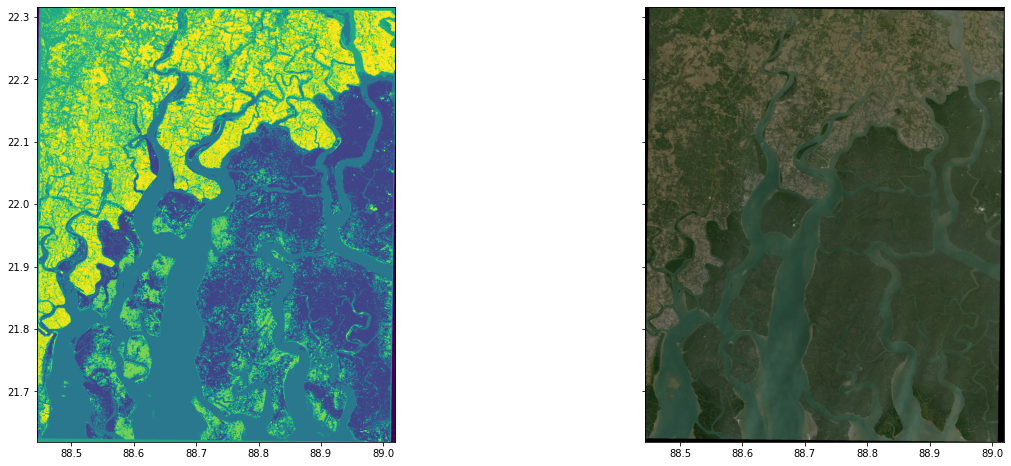

In [ ]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification
raster_file = "/content/drive/MyDrive/model_data/OLI8_San.tif"
output_image = '/content/drive/MyDrive/model_data/classification.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([2,3,4])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
  )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)
